# Machine learning algorithms for coral bleaching classification 

## Load dataset

In [8]:
'''
    Import libraries
'''
from sklearn import datasets
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import sklearn
import seaborn as sb
import matplotlib.pyplot as plt
from numpy import mean 
from numpy import std
import pingouin as pg   
from scipy.stats import shapiro
from scipy.stats import levene 
from scipy.stats import bartlett
from scipy.stats import kruskal
import scikit_posthocs as sp 
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from itertools import combinations, permutations
# check scikit-learn version
print(sklearn.__version__)

0.22.2.post1


In [9]:
'''
    Load full dataset
'''
data = pd.read_csv('df_sst_clouds.csv',low_memory=False)
len(data)  

21003

In [10]:
list(data.columns)

['ITEM_ID',
 'COUNTRY',
 'lat',
 'lon',
 'SEVERITY_CODE',
 'DHW_class',
 'DAY',
 'MONTH',
 'YEAR',
 'full_date',
 'JD',
 'SST',
 'SST_adj_date',
 'SSTrunmax30',
 'SSTrunmax30_adj_date',
 'SSTrunmean30',
 'SSTrunmean30_adj_date',
 'SSTrunmean7',
 'SSTrunmean7_adj_date',
 'SSTrunmax7',
 'SSTrunmax7_adj_date',
 'SSTrunmean90',
 'SSTrunmean90_adj_date',
 'SSTrunmax90',
 'SSTrunmax90_adj_date',
 'DHW',
 'DHW_adj_date',
 'DHWrunmean7',
 'DHWrunmean7_adj_date',
 'DHWrunmax7',
 'DHWrunmax7_adj_date',
 'DHWrunmean30',
 'DHWrunmean30_adj_date',
 'DHWrunmax30',
 'DHWrunmax30_adj_date',
 'DHWrunmean90',
 'DHWrunmean90_adj_date',
 'DHWrunmax90',
 'DHWrunmax90_adj_date',
 'DHW_9',
 'DHW_9_adj_date',
 'CF',
 'CF_adj_date',
 'CFrunmean30',
 'CFrunmean30_adj_date',
 'CFrunmean7',
 'CFrunmean7_adj_date',
 'CFrunmean90',
 'CFrunmean90_adj_date',
 'CF_monmean',
 'CF_monmean_adj_date',
 'CF_a',
 'CF_a_adj_date',
 'CF_a_runmean30',
 'CF_a_runmean30_adj_date',
 'CF_a_runmean7',
 'CF_a_runmean7_adj_date',
 'C

In [16]:
'''
    Subset DF by SEVERITY_CODE [0,1,2,3]
      Severity_code == "-1" is dropped
'''
#data = data.dropna() # drop rows that contains NaN's 
data = data[(data.SEVERITY_CODE == 0)|(data.SEVERITY_CODE == 1)|(data.SEVERITY_CODE == 2)|(data.SEVERITY_CODE == 3)] 
#data = data[(data.YEAR >= 2002)] # First year with more than 100 records
#data = data[(data.YEAR >= 2015) & (data.YEAR <= 2016)] # subset a single event
#data = data[(data.YEAR >= 1997) & (data.YEAR <= 1998)]
#list(data.columns)
data = data.dropna() # drop rows that contains NaN's (if any)
len(data)

20263

In [ ]:
'''
            Restricting to cells with an actual DHW value only
    This step should be used after getting results of complegte dataset
'''
# data = data.drop(data[(data.DHW == 0) & (data.DHW_RMax30 == 0) & (data.DHW_RMax60 == 0) &(data.DHW_RMax90 == 0) & (data.SEVERITY_CODE > 0)].index) 
# len(data)

In [ ]:
'''
        Create dataframes to build independent models 
        Example:
        X1 = data[['var #1','var #2']]  ## features (dependen variable(s))
        X2 = data[['var #1','var #3']] 
        y = data[['independent variable']]  ## labels (indipendent variable)
        The object "X_" can be used to run a specific model, however, to keep it simple, the object "X" is going to be used and edited each time to get printed the results and avoid changing the code in subsequent steps" 
'''
# ## Features (dependent variable)
# X0=data[['DHW']] # better than any othe DHW metric
# X00=data[['DHW_9']] # better than DHW
# X1=data[['DHW', 'CF']] 
# X2=data[['DHW', 'CFrunmean7']]
# X3=data[['DHW', 'CFrunmean30']] 
# X4=data[['DHW', 'CFrunmean90']] # 
# X5=data[['DHW', 'CF_a']]
# X6=data[['DHW', 'CF_a_runmean7']] #
# X7=data[['DHW', 'CF_a_runmean30']] #
# X8=data[['DHW', 'CF_a_runmean90']] # +
# X9=data[['DHW_9','CF_a']] # + better than DHW_9
# X10=data[['DHW_9','CFrunmean7']]
# X11=data[['DHW_9','CFrunmean30']]
# X12=data[['DHW_9','CFrunmean90']]
# X13=data[['DHW_9','CF_a_runmean7']] # 
# X12=data[['DHW_9','CF_a_runmean7']] # +
# X15=data[['DHW_9','CF_a_runmean90']] # 
# X16=data[['DHW_9','CFrunmean7','CD']] # x
# X17=data[['DHW_9','CFrunmean7','WD']] # x
# X18=data[['SSTrunmax90','CF_a_runmean90','WD']] # +++
# X19=data[['DHW','CF_a_runmean7','CV_run7']] # +
# X20=data[['DHW','CF_a_runmean30','CV_run30']] # +
# X21=data[['DHW','CF_a_runmean90','CV_run90']] # -
# X22=data[['SSTrunmean90','CF_a_runmean90','WD']] # +
# X23=data[['SSTrunmean7','CF_a_runmean90','WD']]
# X24=data[['SSTrunmax7','CF_a_runmean90','WD']] # ++
# X25=data[['YEAR','DHW_9','CF_a_runmean7']] # +
# X26=data[['YEAR','DHW','CF_a_runmean90']] # +
# X27=data[['YEAR','CF_a_runmean90']] # -   VIF + 1,5
# X28=data[['YEAR','SSTrunmax7','CFrunmean90']] # 
# X30=data[['YEAR','SSTrunmax90','DHW','CV_run90']] # +++
# X31=data[['YEAR','SSTrunmax90','DHW','CV_run90','CFrunmean90']] # +++
# X32=data[['DHW_adj_date', 'CFrunmean90_adj_date']] # YEAR + DHW_9 VIF + 1.5
# #labels (indipendent variable)
# y=data['SEVERITY_CODE'] 

In [17]:
X = data.loc[:,('DHW','CF_a_runmean90')] 

In [23]:
'''
Iterable object to run the models 
Here you can set the model's desired variables
'''
X=data.loc[:,('DHW','CF_a_runmean30')] ## Features (dependent variable(s)); select desired variables
y=data['SEVERITY_CODE'] # labels (indipendent variable)

In [24]:
'''
    Variance inflation factor VIF
'''
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Get variables for which to compute VIF and add intercept term
#X = data[['lat','lon','DHW','CF_Rmean_14','DAMMM']] 
#X['lat'] = X['lat'].apply(lambda x: int(float(x)))
#X['lon'] = X['lon'].apply(lambda x: int(float(x)))
X['Intercept'] = 1
# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# View results using print
print(vif)

        variables            VIF
0             DHW       1.062086
1  CF_a_runmean90       1.019537
2             lat       1.196563
3            YEAR       1.168861
4       Intercept  725884.260199


# Random forest classifier

In [105]:
'''
    Build the models
'''
model = RandomForestClassifier(n_estimators=200, random_state=3)
model.fit(X,y)
# evaluate the model
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=3)
n_scores = cross_val_score(model, X, y, cv=cv) #n_jobs=-1, error_score='raise'

In [106]:
'''
    Report performance
'''
print('Cross val score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('\n')
# Features importance
print('=== features importances ===')
fi = pd.DataFrame({'feature': list(X.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

Cross val score: 0.602 (0.011)


=== features importances ===


,feature,importance
1,CV_run7,0.351228
2,CF_a_runmean7,0.346545
0,DHW,0.302226
3,Intercept,0.000000


In [107]:
'''
    Confusion matrix
'''
y_pred=model.predict(X)
conf_mat = confusion_matrix(y, y_pred)
conf_mat_norm = confusion_matrix(y, y_pred,normalize='all')
print("=== Confusion matrix ===")
print(conf_mat)
print('\n')
print("=== Confusion matrix normalized ===")
print(conf_mat_norm)
print('\n')
print("=== Classification Report ===")
print(classification_report(y, y_pred))
print('\n')
print('=== Accuracy and Kappa ===')
print('accuracy', metrics.accuracy_score(y, y_pred))
print('\n')
print('kappa', metrics.cohen_kappa_score(y, y_pred))
print('\n')

=== Confusion matrix ===
[[3169  129   67   19]
 [ 161 1752  163   27]
 [  93  151 2218  151]
 [  40   18  158 1626]]


=== Confusion matrix normalized ===
[[0.31874874 0.01297526 0.00673909 0.00191108]
 [0.01619392 0.17622209 0.01639509 0.00271575]
 [0.00935425 0.01518809 0.22309394 0.01518809]
 [0.00402334 0.0018105  0.01589217 0.16354858]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3384
           1       0.85      0.83      0.84      2103
           2       0.85      0.85      0.85      2613
           3       0.89      0.88      0.89      1842

    accuracy                           0.88      9942
   macro avg       0.88      0.88      0.88      9942
weighted avg       0.88      0.88      0.88      9942



=== Accuracy and Kappa ===
accuracy 0.8816133574733453


kappa 0.838921103106355




In [108]:
'''
    Evaluation between classifications models through "log loss"
'''
model_probs = model.predict_proba(X)
score = log_loss(y, model_probs)

'''
    Evaluation between classifications models through "ROC_AUC"
'''
roc_value = roc_auc_score(y, model_probs, multi_class='ovo') # ovo': Computes the average AUC of all possible pairwise combinations of classes


print('=== roc_auc_score ===') 
print(roc_value)
print(' ')
print('=== log_loss_score ===') 
print(score)


=== roc_auc_score ===
0.9861062400376278
 
=== log_loss_score ===
0.32461156839259314


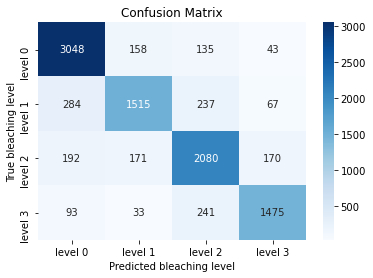

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt     
ax = plt.subplot()
#Heat map with annot=True to annotate cells
sns.heatmap(conf_mat, annot=True, ax = ax, fmt='d', cmap='Blues') # actual cases
#sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, ax = ax, fmt='.2%', cmap='Blues') #percentage
# labels, title and ticks
ax.set_xlabel('Predicted bleaching level');ax.set_ylabel('True bleaching level'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['level 0','level 1','level 2', 'level 3']); ax.yaxis.set_ticklabels(['level 0','level 1','level 2', 'level 3'])
#plt.show()
#plt.savefig('DHW9_CF_a_runmean90.pdf', dpi=300)

In [ ]:
comparisons = pd.DataFrame({'Real':y, 'Predictions':y_pred})
comparisons.to_csv('pred_DHW_CF_a_runeman90.csv')
print(comparisons[['Real','Predictions']])

In [ ]:
data.to_csv('df_for_RFoutputs.csv')